# **Introduction to Hidden Markov Models**

**The Hidden Markov Model (HMM) is a probabilistic model that is used to explain or derive the probability of any random process.** It basically states that an observed event will be related to a set of probability distributions rather than its step-by-step status. Assume the system being modelled is a Markov chain, with some hidden states in the process. In that case, hidden states are a process that is dependent on the main Markov process/chain.

The primary goal of the HMM is to discover information about a Markov chain by observing its hidden states. Considering a Markov process X with hidden states Y, the HMM establishes that the probability distribution of Y for each time stamp must not be dependent on the history of X at that time.

## **Case Study - Context**




The CES program is a monthly survey conducted by the Bureau of Labor Statistics. The program provides employment, hours, and earnings estimates based on payroll records of business establishments. Data produced from the CES survey include nonfarm employment series for all employees, production and nonsupervisory employees, and women employees, as well as average hourly earnings, average weekly hours, monthly umemployment rate and average weekly overtime hours (in manufacturing industries) for both all employees and production and nonsupervisory employees. Labor Force Data comes from the 'Current Population Survey (Household Survey)'.

**The Unemployment Rate represents the number of unemployed as a percentage of the labor force.**

**This rate is also defined as the U-3 measure of labor underutilization.**

## **Objective**

In this notebook, we'll look at how to use **Hidden Markov Models (HMM) to predict the Unemployment Rate over the years.** Using a HMM, we will predict whether the unemployment rate will rise or fall each year based on the data.

When we examine the relationship between the provided data and the unemployment rate, we discover that the unemployment rate peaks whenever there is a recession/pandemic. So we are interested in how we can build Hidden Markov Models (HMM) by using the data we have to identify this. Furthermore, we want to see if our model can predict the unemployment rate more accurately.

## **Dataset**


We will use **Unemployment Rate data from the U.S. Bureau of Labor Statistics** (monthly data from 1948 to 2022).

## **Installing the hmmlearn and stats libraries**


*   `hmmlearn` is a set of algorithms for unsupervised learning and inference of Hidden Markov Models.
*   `stats` is a pure Python module providing basic statistics functions similar to those found on scientific calculators.



In [1]:
!pip install stats
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24283 sha256=01eef272224286bee238f4b19c3feaf0bdf77e6933758d396828dac4c7b2687e
  Stored in directory: /root/.cache/pip/wheels/c9/85/bc/3371b9bce1e4f7b8b638e8c968a4dbd74db171ee180c48f808
Successfully built stats
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.1 MB/s eta 0:00:00


## **Importing the necessary libraries**

In [2]:
import stats  # Library which provides basic statistics functions similar to those found on scientific calculators

import pandas as pd # Library used for data manipulation and analysis
import numpy as np  # Library used for working with arrays
import math # Library to use mathematical functions

import datetime # Library for manipulating dates and times.

from copy import deepcopy

import matplotlib.pyplot as plt # Library for plots and visualisations
%matplotlib inline
from pylab import rcParams

import seaborn as sns  # Library for advanced visualisations
sns.set()

from tqdm import tqdm

from sklearn.linear_model import LinearRegression

from hmmlearn.hmm import GaussianHMM # Library for supervised learning of HMMs
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('hmmlearn').setLevel(logging.ERROR)

## **Reading the Unemployment Rate data**

In [3]:
dataset=pd.read_csv('UNEMPRATE.csv')

In [4]:
dataset.tail()

,DATE,UNRATE
886,2021-11-01,4.2
887,2021-12-01,3.9
888,2022-01-01,4.0
889,2022-02-01,3.8
890,2022-03-01,3.6


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    891 non-null    object 
 1   UNRATE  891 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.0+ KB


## **Employment stability over the years**

In [6]:
dataset['Month']=pd.DatetimeIndex(dataset['DATE']).month
dataset['Year']=pd.DatetimeIndex(dataset['DATE']).year

In [7]:
ma_5_yr=dataset['UNRATE'].rolling(60).mean()
ma_3_yr=dataset['UNRATE'].rolling(36).mean()

<Axes: xlabel='Year', ylabel='UNRATE'>

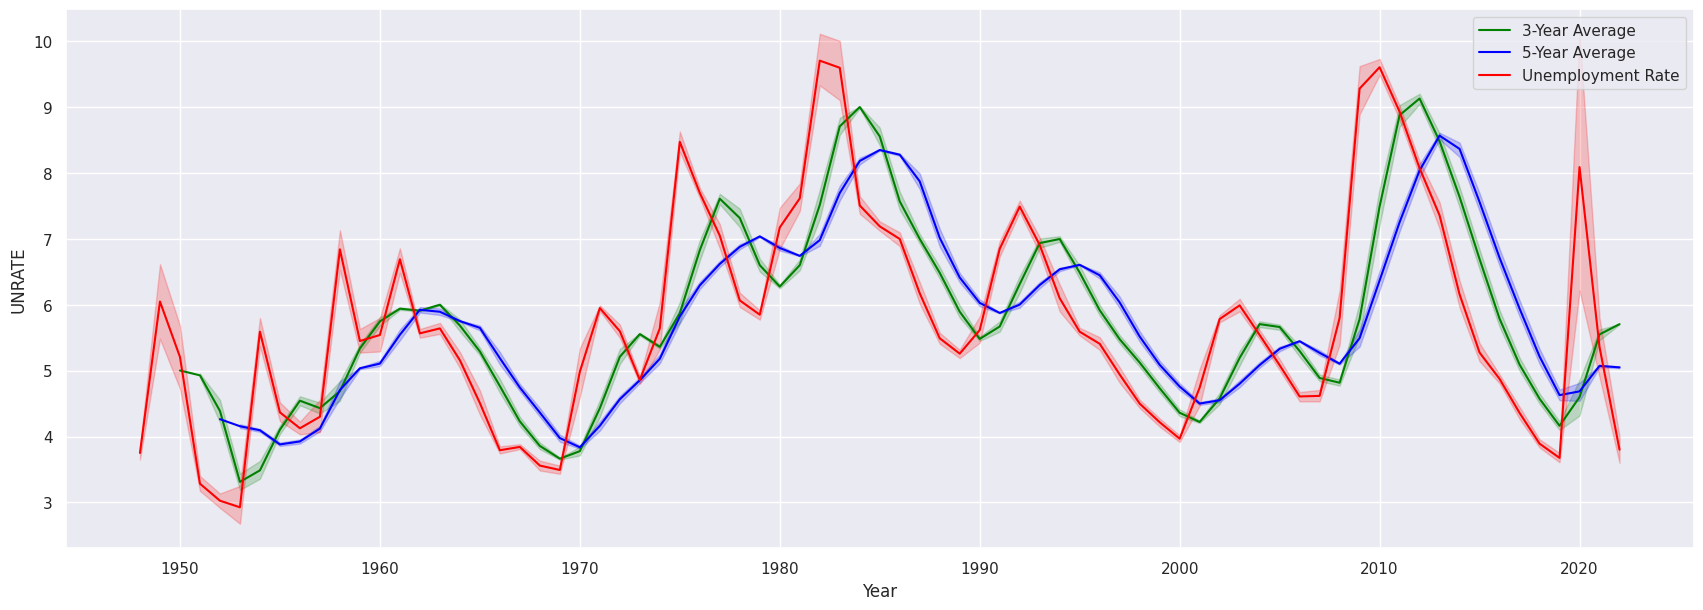

In [8]:
plt.figure(figsize=(21,7))
sns.lineplot(x=dataset['Year'],y=ma_3_yr,color='green',label="3-Year Average")
sns.lineplot(x=dataset['Year'],y=ma_5_yr,color='blue',label="5-Year Average")
sns.lineplot(x=dataset['Year'],y=dataset['UNRATE'],color='red',label="Unemployment Rate")

**We observe periods of positive and negative growth. Possibly, there is a hidden process that is influencing the trends.**

The portion of the phenomenon that cannot be observed is represented by a hidden process and it is modeled using a Markov process model.
We can see the 5-year average is far from the actual trend. The 3-year average looks closer. Let's find out the most stable years.

<Axes: xlabel='Year', ylabel='UNRATE'>

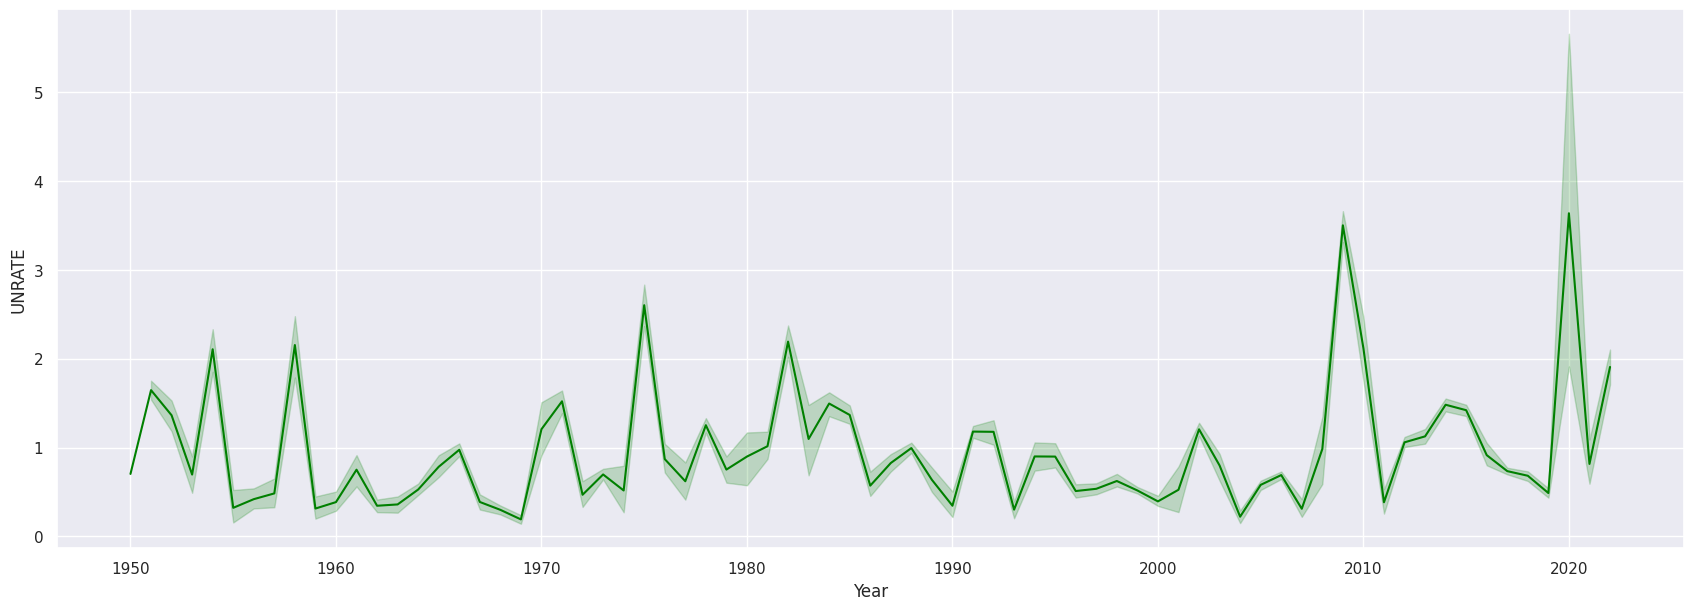

In [9]:
plt.figure(figsize=(21,7))
sns.lineplot(x=dataset['Year'],y=np.abs(ma_3_yr-dataset['UNRATE']),color='green')

### **Most Stable Years**

In [10]:
dataset['DATE'][(np.abs(ma_3_yr-dataset['UNRATE'])).argmin()]

'2001-02-01'

In [11]:
dataset['DATE']=pd.to_datetime(dataset['DATE'])

In [12]:
from datetime import datetime

### **Year-wise Unemployment Rate**

In [13]:
dataset.groupby(['Year'])['UNRATE'].median()

Year
1948    3.80
1949    6.30
1950    5.20
1951    3.25
1952    3.00
        ... 
2018    3.85
2019    3.60
2020    7.40
2021    5.60
2022    3.80
Name: UNRATE, Length: 75, dtype: float64

### **Fluctuation in monthly unemployment for each year**

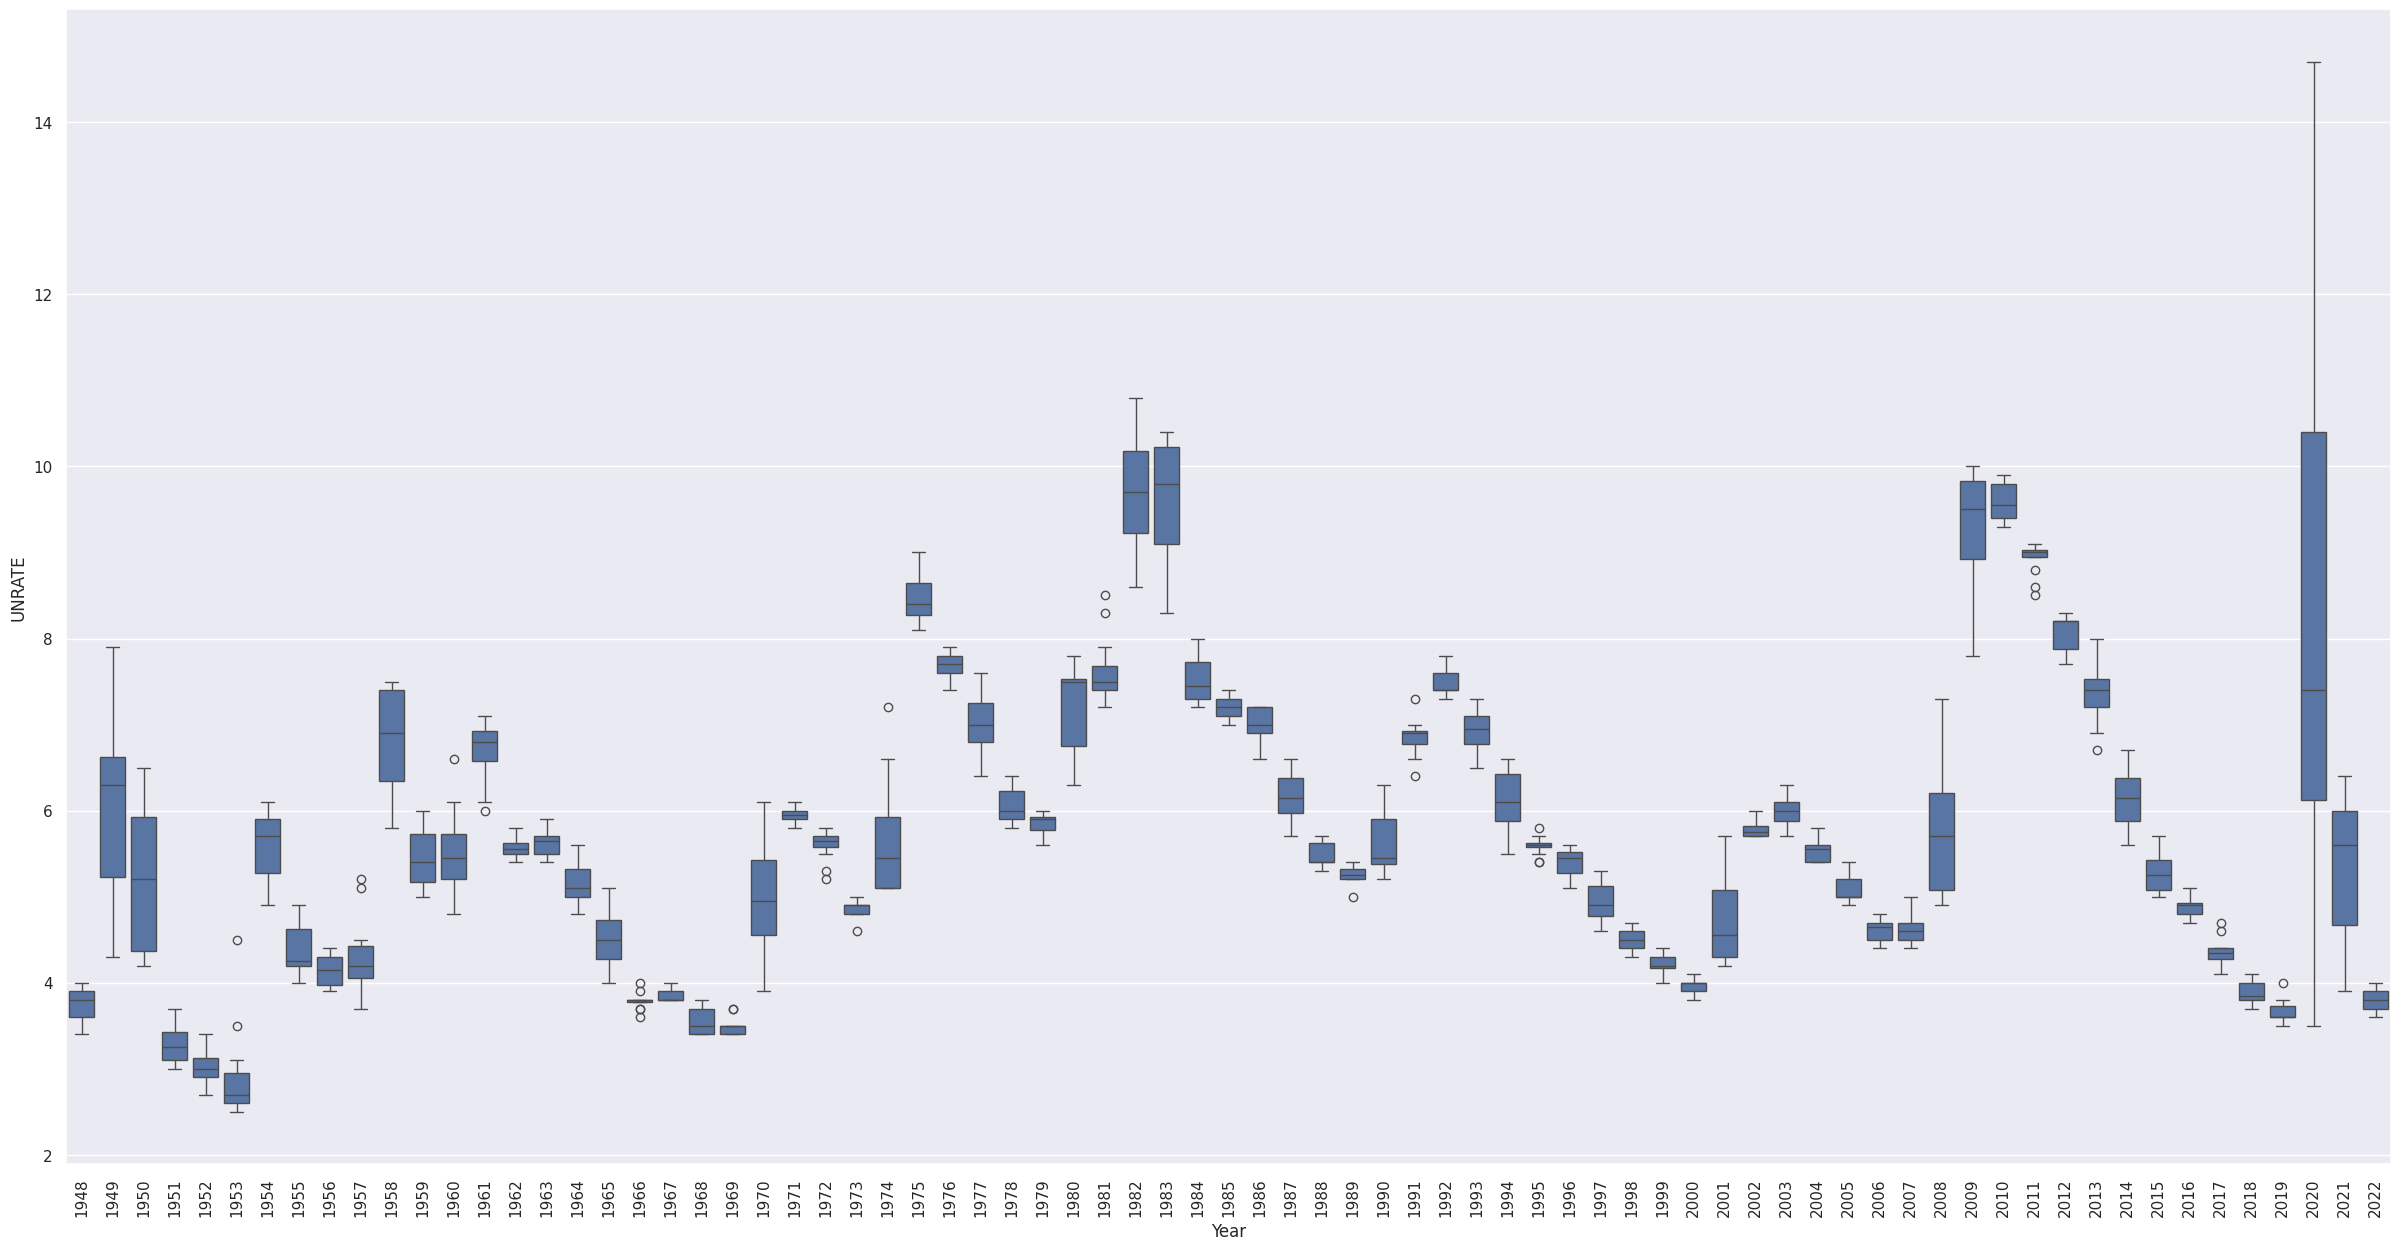

In [14]:
plt.figure(figsize=(30,15))
sns.boxplot(x=dataset['Year'],y=dataset['UNRATE'])
plt.xticks(rotation=90)
plt.show()

In [15]:
dataset.groupby(['Year'])['UNRATE'].std().reset_index().dropna().sort_values(['UNRATE'],ascending=False)[:10].reset_index(drop=True)

,Year,UNRATE
0,2020,3.616743
1,1949,1.031768
2,1950,0.894893
3,2021,0.831711
4,2008,0.780443
5,1983,0.761577
6,1982,0.719164
7,2009,0.696528
8,1974,0.674818
9,1970,0.664466


**The years with the highest unemployment rate correspond to recession/COVID periods. This is to be expected, as unemployment spikes during times of economic distress.** COVID-19 had a dramatic effect on the labor market. Unlike a strike or weather event, the effect was nationwide in the US and, for some industries, sustained over a long period. The Recession of 1949 was also a downturn in the United States lasting for 11 months. Hence, 2020 has the highest unemployment rate followed by 1949.

### **Fluctuation in employment for a particular month**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

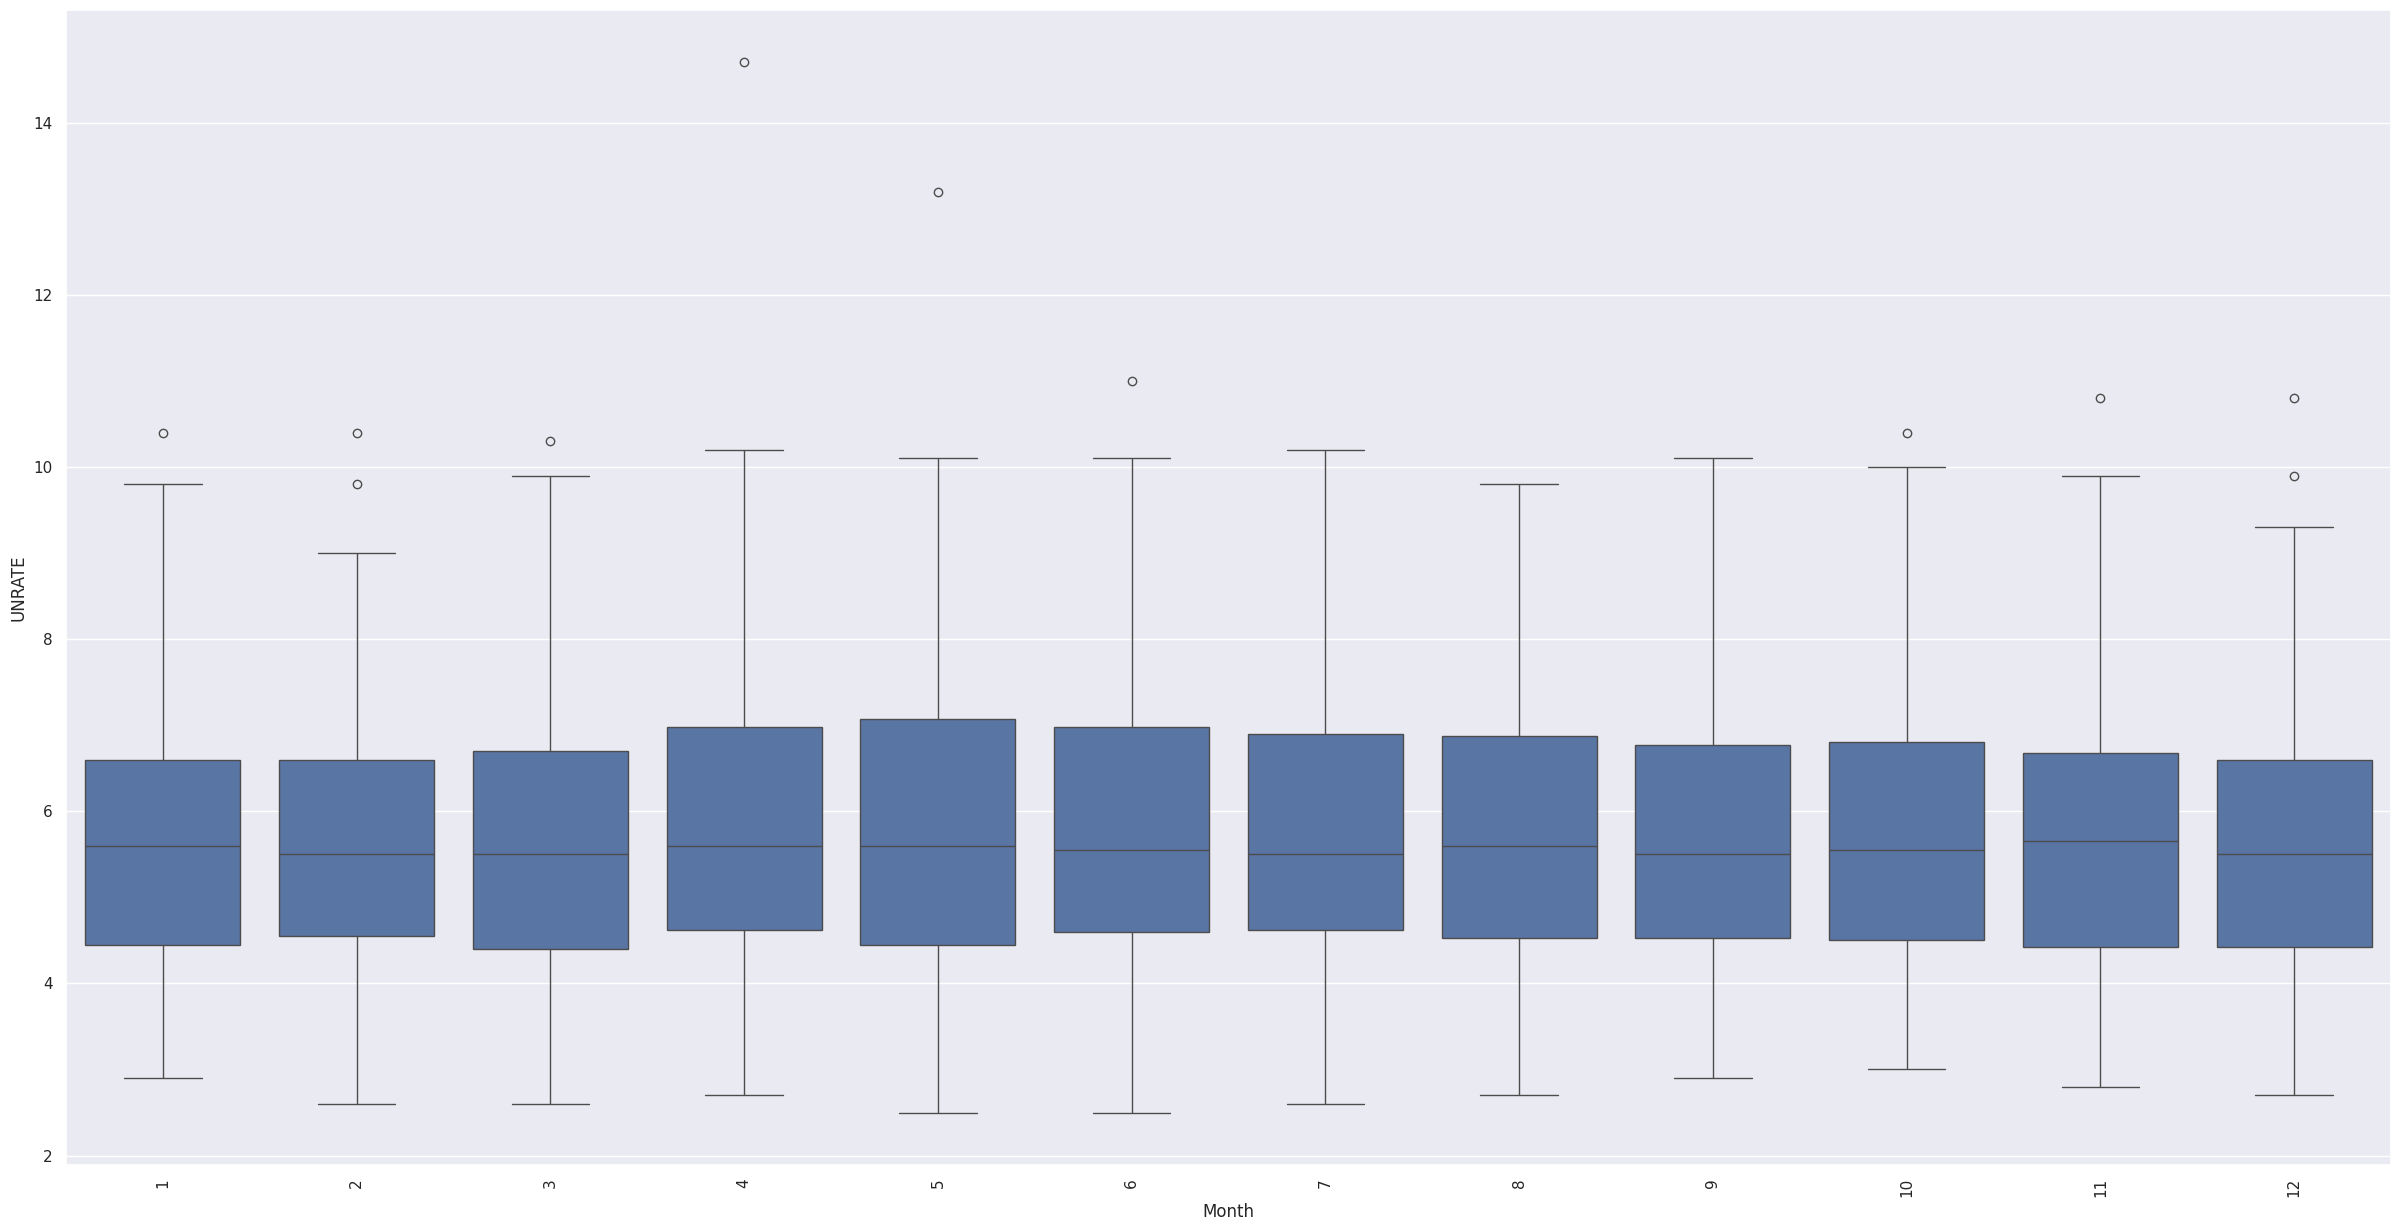

In [16]:
plt.figure(figsize=(30,15))
sns.boxplot(x=dataset['Month'],y=dataset['UNRATE'])
plt.xticks(rotation=90)

**No fluctuation reflects that the month has limited role in determining unemeployment**.

Since each month is present in every year, the distribution is similar at month level.


### **Checking for seasonality in the data**




Seasonality is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal.

In [17]:
dataset['SEASONALITY AND NOISE'] = dataset['UNRATE']/ma_5_yr

In [18]:
#first add a month column
#dataset['Month'] = dataset.index.strftime('%m').astype(np.int)

#initialize the month based dictionaries to store the running total of the month wise  seasonal sums and counts
average_seasonal_values = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

average_seasonal_value_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

#calculate the sums and counts
for i in range(0, dataset['SEASONALITY AND NOISE'].size):
    if math.isnan(dataset['SEASONALITY AND NOISE'][i]) is False:
        average_seasonal_values[dataset['Month'][i]] = average_seasonal_values[dataset['Month'][i]] +dataset['SEASONALITY AND NOISE'][i]
        average_seasonal_value_counts[dataset['Month'][i]] = average_seasonal_value_counts[dataset['Month'][i]] + 1

#create a new column in the data frame and fill it with the value of the average seasonal component for the corresponding month
for i in range(1, 13):
    average_seasonal_values[i] = average_seasonal_values[i] / average_seasonal_value_counts[i]



dataset['SEASONALITY'] = np.nan

for i in range(0, dataset['SEASONALITY AND NOISE'].size):
    if math.isnan(dataset['SEASONALITY AND NOISE'][i]) is False:
        dataset['SEASONALITY'][i] = average_seasonal_values[dataset['Month'][i]]

<Axes: xlabel='Year', ylabel='SEASONALITY AND NOISE'>

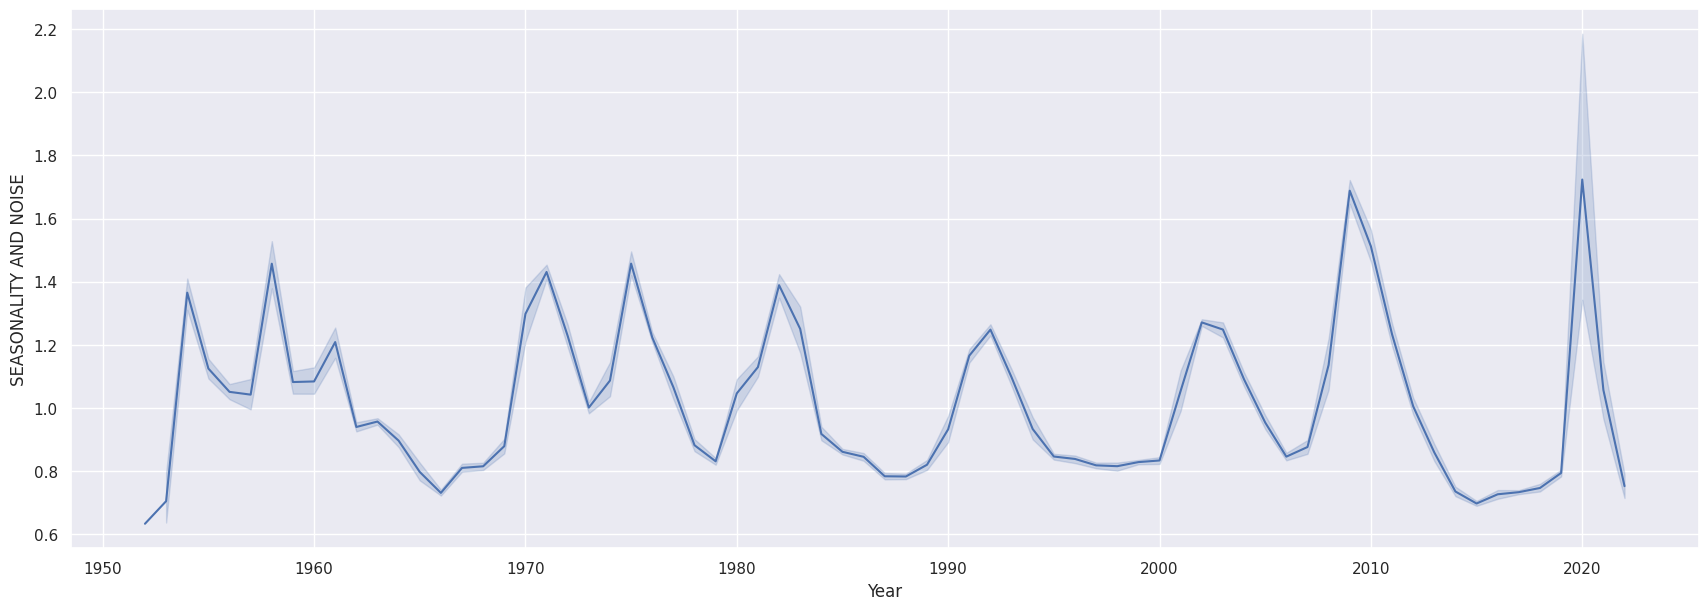

In [19]:
plt.figure(figsize=(21,7))
sns.lineplot(x=dataset['Year'],y=dataset['SEASONALITY AND NOISE'])

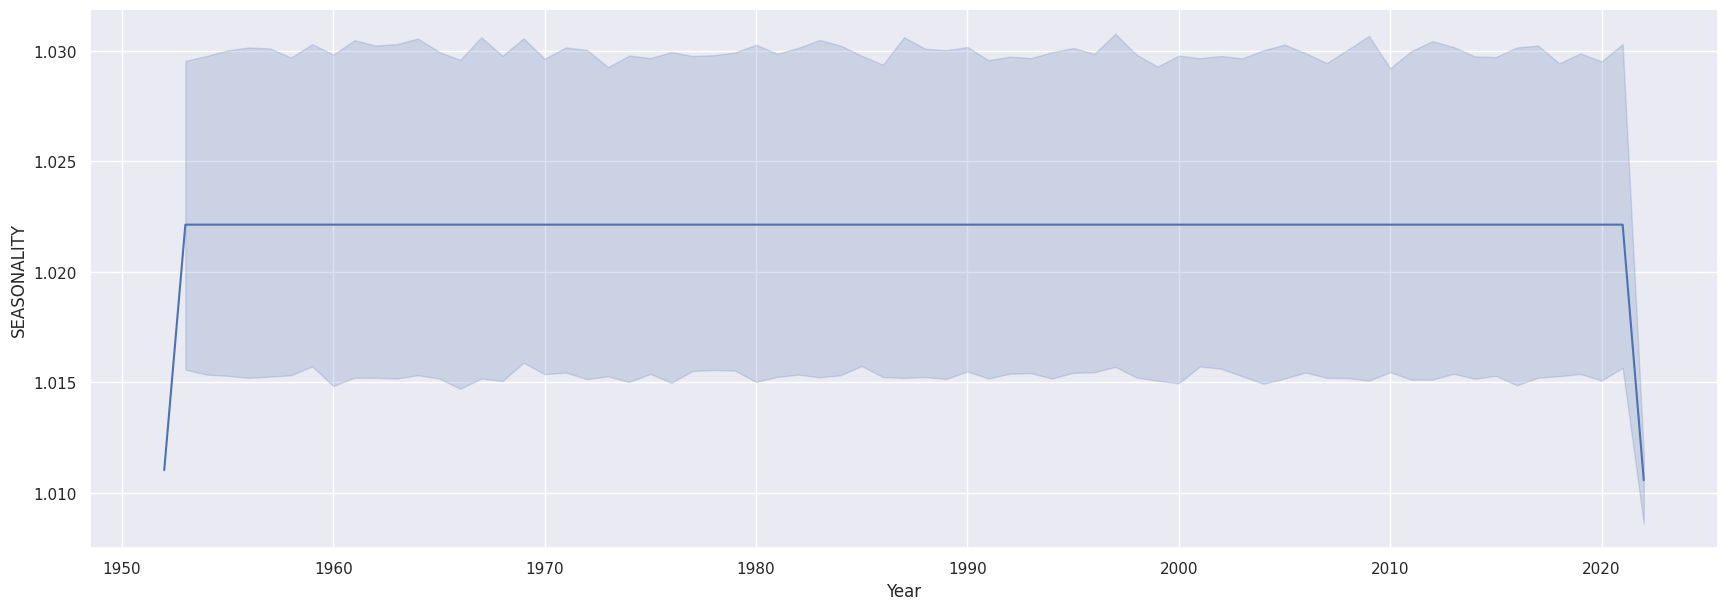

In [20]:
plt.figure(figsize=(21,7))
sns.lineplot(x=dataset['Year'],y=dataset['SEASONALITY'])

plt.show()


**No seasonality observed in the data for the 5 yr moving average**

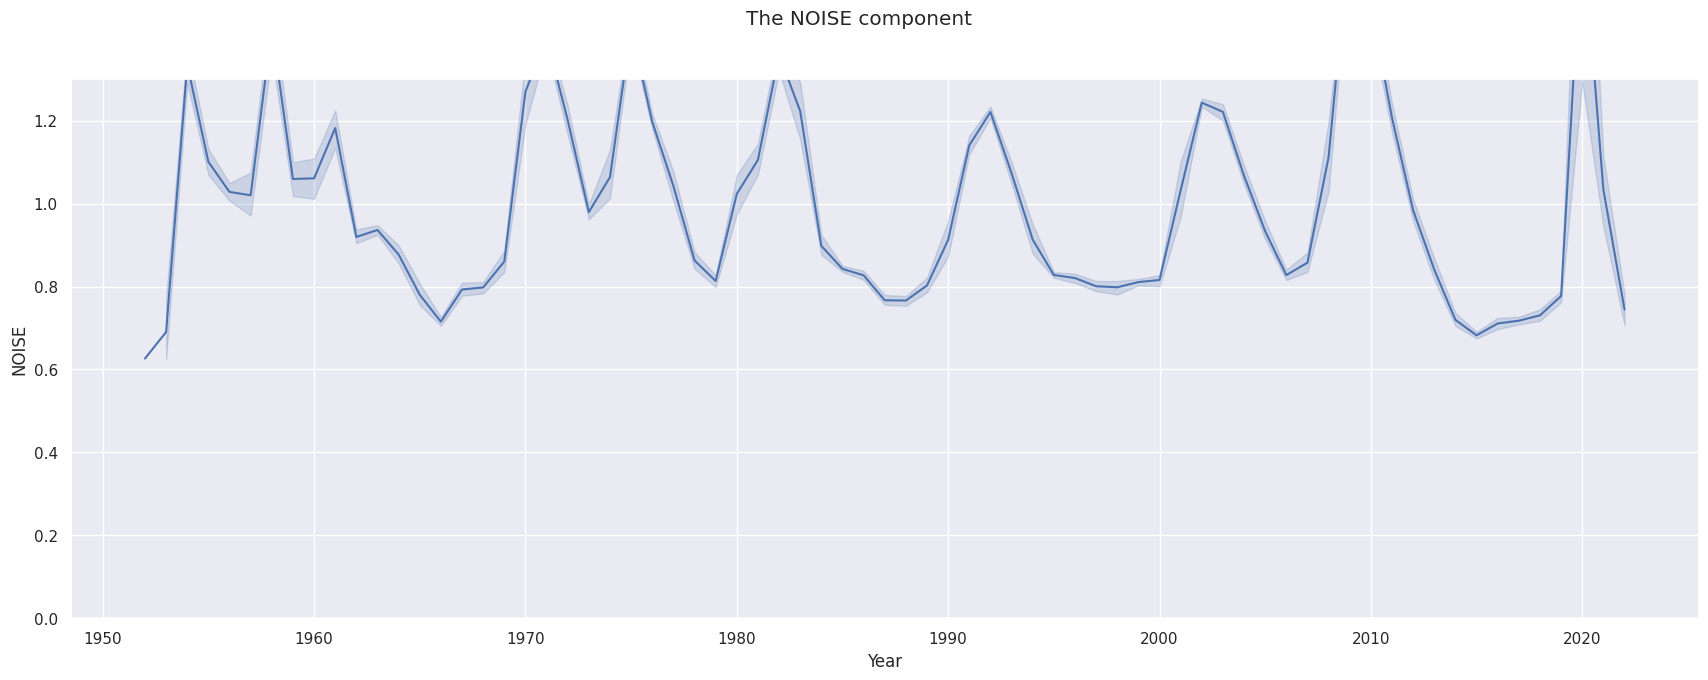

In [21]:
dataset['NOISE'] = dataset['SEASONALITY AND NOISE']/dataset['SEASONALITY']

#plot the seasonal component

fig = plt.figure(figsize=(21,7))

fig.suptitle('The NOISE component')

plt.ylim(0, 1.3)

sns.lineplot(x=dataset['Year'],y=dataset['NOISE'])

plt.show()


Most of the fluctuation is reflecting as noise. No seasonality and trend in data suggests we cannot decompose this time series into trend and sesonality components.

The unemeployment rate, as suspected, seems to be determined more by underlying economic states like recession, COVID, budget, and investments in the market. HMMs can be used to identify such hidden states that can help us in predicting these patterns better.

## **HMM Training**



A HMM can be used to study a phenomena in which some portion of phenomena is directly observed while rest of it can't be observed. The effect of the unobserved portion can only be estimated and not exactly computed.

We represent such phenomena using a mixture of two random processes.

One of the two processes is a ‘**visible process**’. It is used to represent the observable portion of the phenomenon. The visible process is modeled using a suitable regression model such as ARIMA, the Integer Poisson model, or the ever popular Linear Model.

The portion that cannot be observed is represented by a ‘**hidden process**’ which is modeled using a Markov process model.

**Reference:** https://towardsdatascience.com/a-math-lovers-guide-to-hidden-markov-models-ad718df9fde8

In [22]:
values = dataset['UNRATE'][:-24].values.reshape(-1,1)

In [23]:
N = 650
train = values[:N]
test = values[N:]

## **Hyperparameter Tuning**



There are two main parameters in HMMs:


*  n_components ----> Determines the number of hidden states to be used in the model

*  Algorithm ----> The Viterbi Algorithm






**The Viterbi algorithm** is a dynamic programming algorithm for obtaining the maximum a-posteriori probability estimate of the most likely sequence of hidden states, called the Viterbi path, that results in a sequence of observed events, especially in the context of Markov information sources and Hidden Markov Models (HMM).

In [24]:
hyperparameter_grid = {
    'n_components': [2,5,7,10,12,15,17,20,22,25,27,30,32,35,37,40],
    'covariance_type' :'diag',
    'algorithm' : ['algo','verterbi'],
    'n_iter' :10000
}

In [25]:
##Create and store all models combinations of n_components and algo
n_comp=[]
mse=[]
mae=[]
al=[]

for i in range(2,50,2):
  for algo in ['map','viterbi']:
    model_hmm = GaussianHMM(n_components=i+2, covariance_type="diag", algorithm =algo, n_iter=10000, random_state = 42)
    model_hmm.fit(train)
    prediction_hmm = model_hmm.predict(test)
    n_comp.append(i+2)
    al.append(algo)
    mse.append(mean_squared_error(test, prediction_hmm) ** (1 / 2))
    mae.append(mean_absolute_error(test, prediction_hmm))

In [26]:
model_df=pd.DataFrame({'comp':n_comp,'mse':mse,'mae':mae,'al':algo})

In [27]:
model_df[model_df['mae']==model_df['mae'].min()]

,comp,mse,mae,al
6,10,3.068691,2.593548,viterbi


<Axes: xlabel='comp', ylabel='mse'>

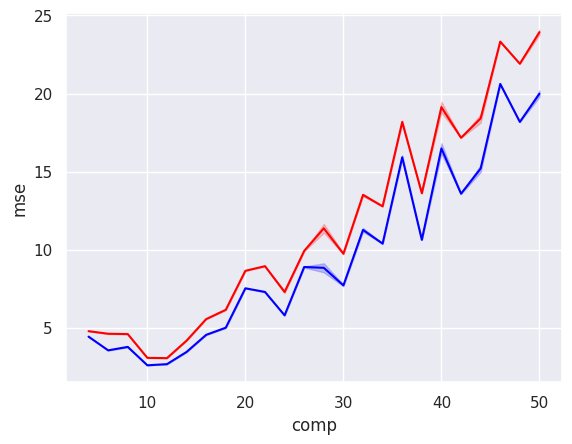

In [28]:
sns.lineplot(x=model_df['comp'],y=model_df['mse'],color='red')
sns.lineplot(x=model_df['comp'],y=model_df['mae'],color='blue')

In [29]:
model_hmm = GaussianHMM(n_components=14, covariance_type="diag", algorithm = 'viterbi', n_iter=10000, random_state = 42)
model_hmm.fit(train)
prediction_hmm = model_hmm.predict(test)

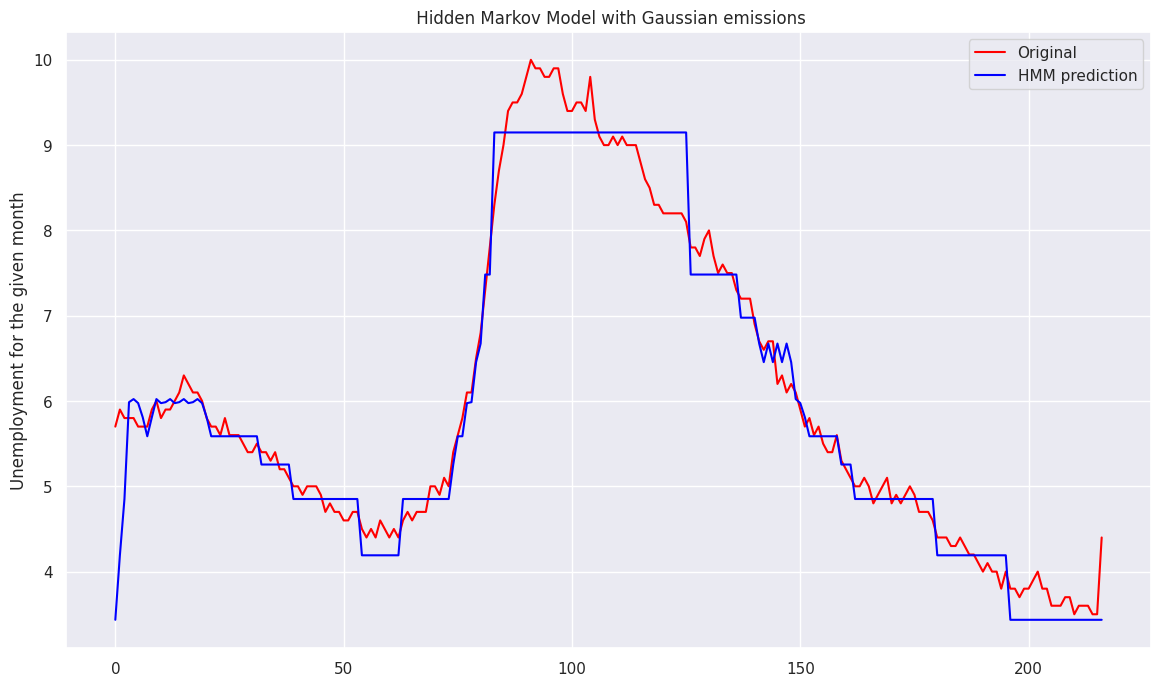

In [30]:
labels = model_hmm.predict(test)
means = np.zeros_like(test)
for i in range(model_hmm.n_components):
    means[labels == i] = model_hmm.means_[i]

plt.figure(figsize=(14, 8))
plt.title(' Hidden Markov Model with Gaussian emissions')
plt.ylabel('Unemployment for the given month')
plt.plot(test, color = 'red', label = 'Original')
plt.plot(means, color = 'blue', label = 'HMM prediction')
plt.legend()
plt.show()

## **Model Performance Evaluation**

In [31]:
rmse_hmm = mean_squared_error(test, prediction_hmm) ** (1 / 2)
rmse_hmm

4.193180770841931

In [32]:
mae_hmm = mean_absolute_error(test, prediction_hmm)
mae_hmm

3.473732718894009

## **Conclusions**


1.  We found the Hidden Markov Model to follow the actual data very closely.
2.  The peaks seem to be modelled less accurately in comparison to the original data.

